1/1 [==============================] - 0s 95ms/step
0/10 [D loss: 0.7591982483863831 | D accuracy: 0.0] [G loss: 0.6362563371658325]
4/4 [==============================] - 0s 88ms/step
Epoch 1/5
33/33 [==============================] - 6s 106ms/step - loss: 1.8411 - accuracy: 0.2091 - val_loss: 1.7293 - val_accuracy: 0.1220
Epoch 2/5
33/33 [==============================] - 3s 76ms/step - loss: 1.8096 - accuracy: 0.1749 - val_loss: 1.6291 - val_accuracy: 0.2195
Epoch 3/5
33/33 [==============================] - 3s 79ms/step - loss: 1.7095 - accuracy: 0.1863 - val_loss: 1.6342 - val_accuracy: 0.1951
Epoch 4/5
33/33 [==============================] - 3s 80ms/step - loss: 1.6674 - accuracy: 0.2319 - val_loss: 1.6667 - val_accuracy: 0.1463
Epoch 5/5
33/33 [==============================] - 3s 82ms/step - loss: 1.6434 - accuracy: 0.2395 - val_loss: 1.6393 - val_accuracy: 0.1707


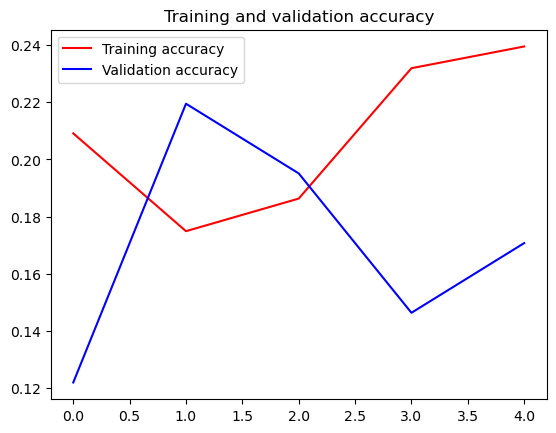

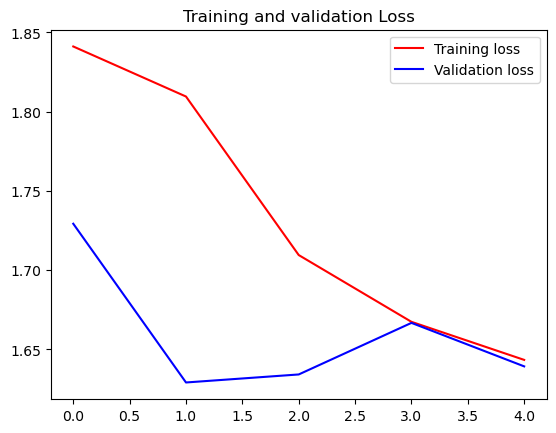

1/1 [==============================] - 1s 819ms/step
The predicted class for the image is: Alternaria
Confidence level: 0.27


In [54]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, Reshape, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
data_dir = r'D:\\GAN PROJECT\\DATASET\\Training Data'
categories = ["Alternaria", "Anthracnose", "Black Mould Rot", "Healthy", "Stem end Rot"]

# Function to load and preprocess images
def load_images(data_dir):
    image_paths = []
    labels = []
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for image_filename in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, image_filename))
            labels.append(category)
    return image_paths, labels

# Load and preprocess the images
image_paths, labels = load_images(data_dir)

# Convert labels to numeric values
label_map = {category: idx for idx, category in enumerate(categories)}
numeric_labels = [label_map[label] for label in labels]

# Convert images to arrays
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

combined_images = np.array([preprocess_image(path) for path in image_paths])
combined_labels = np.array(numeric_labels)

# Convert labels to categorical
combined_labels = to_categorical(combined_labels, num_classes=len(categories))

# Split data
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# GAN Definitions

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 16 * 16, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile GAN
def compile_gan(generator, discriminator, gan):
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
compile_gan(generator, discriminator, gan)

# Training GAN
def train_gan(epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        real_labels = np.ones((batch_size, 1))
        
        # Generate fake images
        noise = np.random.randn(batch_size, latent_dim)
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        # Train discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss_real[0]} | D accuracy: {100 * d_loss_real[1]}] [G loss: {g_loss}]")

# Define training parameters
latent_dim = 100
epochs = 10  # Reduced epochs
batch_size = 4  # Reduced batch size

train_gan(epochs, batch_size, latent_dim)

# Generate synthetic images
def generate_synthetic_images(num_images, latent_dim):
    noise = np.random.randn(num_images, latent_dim)
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2.0  # Rescale to [0, 1]
    return synthetic_images

synthetic_images = generate_synthetic_images(100, latent_dim)

# Combine real and synthetic data
synthetic_labels = np.random.choice(len(categories), size=synthetic_images.shape[0])
synthetic_labels = to_categorical(synthetic_labels, num_classes=len(categories))
combined_images = np.concatenate((train_images, synthetic_images), axis=0)
combined_labels = np.concatenate((train_labels, synthetic_labels), axis=0)

# Train classifier
classifier_batch_size = 8
train_generator = ImageDataGenerator(rescale=1./255).flow(combined_images, combined_labels, batch_size=classifier_batch_size)

base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

classifier_epochs = 5
history = model.fit(train_generator, epochs=classifier_epochs, steps_per_epoch=len(train_generator), validation_data=(test_images, test_labels), verbose=1)

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Save the classifier model
model.save('mango_disease_model_with_gan.h5')

# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Training Data\Black Mould Rot\aspergillus_042.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"The predicted class for the image is: {predicted_class}")
print(f"Confidence level: {confidence:.2f}")


1/1 [==============================] - 0s 309ms/step
0/10 [D loss: 0.7067206501960754 | D accuracy: 50.0] [G loss: 0.5775620341300964]
4/4 [==============================] - 0s 113ms/step
Epoch 1/5
33/33 [==============================] - 6s 119ms/step - loss: 1.8563 - accuracy: 0.2091 - val_loss: 1.6673 - val_accuracy: 0.1463
Epoch 2/5
33/33 [==============================] - 3s 91ms/step - loss: 1.7104 - accuracy: 0.1977 - val_loss: 1.6837 - val_accuracy: 0.1707
Epoch 3/5
33/33 [==============================] - 3s 93ms/step - loss: 1.6835 - accuracy: 0.2357 - val_loss: 1.6858 - val_accuracy: 0.1463
Epoch 4/5
33/33 [==============================] - 3s 92ms/step - loss: 1.6837 - accuracy: 0.2091 - val_loss: 1.6529 - val_accuracy: 0.1463
Epoch 5/5
33/33 [==============================] - 3s 92ms/step - loss: 1.6914 - accuracy: 0.2091 - val_loss: 1.6304 - val_accuracy: 0.2927


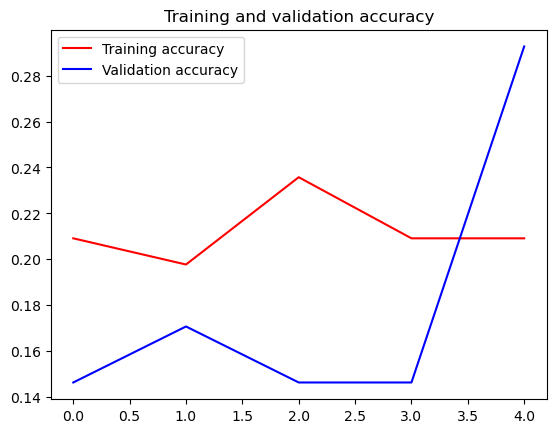

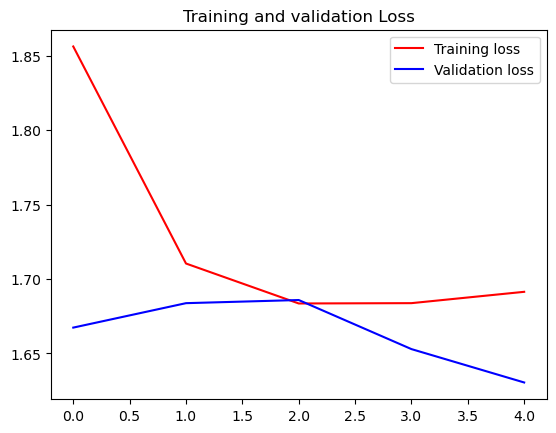

1/1 [==============================] - 1s 990ms/step
The predicted class for the image is: Healthy
Confidence level: 0.23


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, Reshape, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
data_dir = r'D:\\GAN PROJECT\\DATASET\\Training Data'
categories = ["Alternaria", "Anthracnose", "Black Mould Rot", "Healthy", "Stem end Rot"]

# Function to load and preprocess images
def load_images(data_dir):
    image_paths = []
    labels = []
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for image_filename in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, image_filename))
            labels.append(category)
    return image_paths, labels

# Load and preprocess the images
image_paths, labels = load_images(data_dir)

# Convert labels to numeric values
label_map = {category: idx for idx, category in enumerate(categories)}
numeric_labels = [label_map[label] for label in labels]

# Convert images to arrays
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

combined_images = np.array([preprocess_image(path) for path in image_paths])
combined_labels = np.array(numeric_labels)

# Convert labels to categorical
combined_labels = to_categorical(combined_labels, num_classes=len(categories))

# Split data
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# GAN Definitions

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 16 * 16, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile GAN
def compile_gan(generator, discriminator, gan):
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
compile_gan(generator, discriminator, gan)

# Training GAN
def train_gan(epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        real_labels = np.ones((batch_size, 1))
        
        # Generate fake images
        noise = np.random.randn(batch_size, latent_dim)
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        # Train discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss_real[0]} | D accuracy: {100 * d_loss_real[1]}] [G loss: {g_loss}]")

# Define training parameters
latent_dim = 100
epochs = 10  # Reduced epochs
batch_size = 4  # Reduced batch size

train_gan(epochs, batch_size, latent_dim)

# Generate synthetic images
def generate_synthetic_images(num_images, latent_dim):
    noise = np.random.randn(num_images, latent_dim)
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2.0  # Rescale to [0, 1]
    return synthetic_images

synthetic_images = generate_synthetic_images(100, latent_dim)

# Combine real and synthetic data
synthetic_labels = np.random.choice(len(categories), size=synthetic_images.shape[0])
synthetic_labels = to_categorical(synthetic_labels, num_classes=len(categories))
combined_images = np.concatenate((train_images, synthetic_images), axis=0)
combined_labels = np.concatenate((train_labels, synthetic_labels), axis=0)

# Train classifier
classifier_batch_size = 8
train_generator = ImageDataGenerator(rescale=1./255).flow(combined_images, combined_labels, batch_size=classifier_batch_size)

base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

classifier_epochs = 5
history = model.fit(train_generator, epochs=classifier_epochs, steps_per_epoch=len(train_generator), validation_data=(test_images, test_labels), verbose=1)

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Save the classifier model
model.save('mango_disease_model_with_gan.h5')

# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Training Data\Black Mould Rot\aspergillus_042.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"The predicted class for the image is: {predicted_class}")
print(f"Confidence level: {confidence:.2f}")


In [3]:
# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'C:\Users\balas\OneDrive\Desktop\istockphoto-477425106-612x612.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"The predicted class for the image is: {predicted_class}")
print(f"Confidence level: {confidence:.2f}")


1/1 [==============================] - 0s 83ms/step
The predicted class for the image is: Alternaria
Confidence level: 0.27


1/1 [==============================] - 0s 216ms/step
0/1000 [D loss: 0.6809172630310059 | D accuracy: 71.875] [G loss: 0.5976884365081787]
1/1 [==============================] - 0s 155ms/step
100/1000 [D loss: 0.6504720449447632 | D accuracy: 65.625] [G loss: 0.9167380928993225]
1/1 [==============================] - 0s 143ms/step
200/1000 [D loss: 0.7177673578262329 | D accuracy: 50.0] [G loss: 0.7444612979888916]
1/1 [==============================] - 0s 191ms/step
300/1000 [D loss: 0.7189520597457886 | D accuracy: 46.875] [G loss: 0.7063783407211304]
1/1 [==============================] - 0s 181ms/step
400/1000 [D loss: 0.6824742555618286 | D accuracy: 59.375] [G loss: 0.7128692865371704]
1/1 [==============================] - 0s 165ms/step
500/1000 [D loss: 0.6904926300048828 | D accuracy: 50.0] [G loss: 0.8509975671768188]
1/1 [==============================] - 0s 174ms/step
600/1000 [D loss: 0.6412975788116455 | D accuracy: 65.625] [G loss: 0.645229697227478]
1/1 [===============

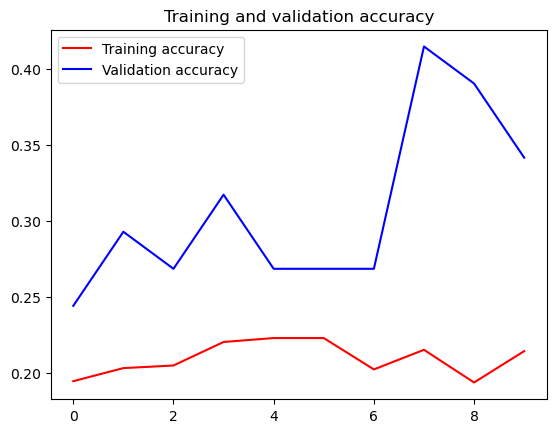

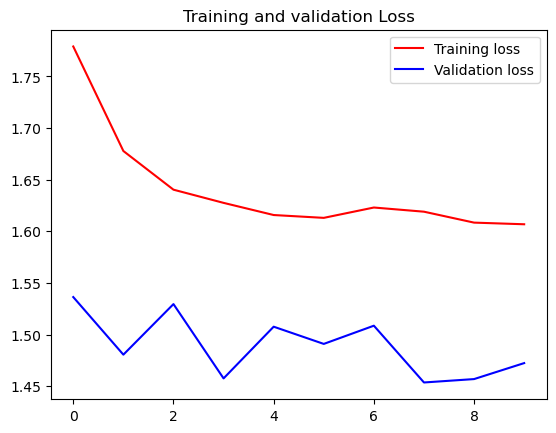

1/1 [==============================] - 1s 866ms/step
The predicted class for the image is: Healthy
Confidence level: 0.24


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, Reshape, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
data_dir = r'D:\\GAN PROJECT\\DATASET\\Training Data'
categories = ["Alternaria", "Anthracnose", "Black Mould Rot", "Healthy", "Stem end Rot"]

# Function to load and preprocess images
def load_images(data_dir):
    image_paths = []
    labels = []
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for image_filename in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, image_filename))
            labels.append(category)
    return image_paths, labels

# Load and preprocess the images
image_paths, labels = load_images(data_dir)

# Convert labels to numeric values
label_map = {category: idx for idx, category in enumerate(categories)}
numeric_labels = [label_map[label] for label in labels]

# Convert images to arrays
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

combined_images = np.array([preprocess_image(path) for path in image_paths])
combined_labels = np.array(numeric_labels)

# Convert labels to categorical
combined_labels = to_categorical(combined_labels, num_classes=len(categories))

# Split data
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# GAN Definitions

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 16 * 16, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile GAN
def compile_gan(generator, discriminator, gan):
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
compile_gan(generator, discriminator, gan)

# Training GAN
def train_gan(epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        real_labels = np.ones((batch_size, 1))
        
        # Generate fake images
        noise = np.random.randn(batch_size, latent_dim)
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        # Train discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss_real[0]} | D accuracy: {100 * d_loss_real[1]}] [G loss: {g_loss}]")

# Define training parameters
latent_dim = 100
epochs = 1000  # Increased epochs for GAN training
batch_size = 32  # Reduced batch size

train_gan(epochs, batch_size, latent_dim)

# Generate synthetic images
def generate_synthetic_images(num_images, latent_dim):
    noise = np.random.randn(num_images, latent_dim)
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2.0  # Rescale to [0, 1]
    return synthetic_images

synthetic_images = generate_synthetic_images(1000, latent_dim)

# Combine real and synthetic data
synthetic_labels = np.random.choice(len(categories), size=synthetic_images.shape[0])
synthetic_labels = to_categorical(synthetic_labels, num_classes=len(categories))
combined_images = np.concatenate((train_images, synthetic_images), axis=0)
combined_labels = np.concatenate((train_labels, synthetic_labels), axis=0)

# Train classifier
classifier_batch_size = 32
train_generator = datagen.flow(combined_images, combined_labels, batch_size=classifier_batch_size)

base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

classifier_epochs = 10  # Increased epochs for classifier
history = model.fit(train_generator, epochs=classifier_epochs, validation_data=(test_images, test_labels), verbose=1)

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Save the classifier model
model.save('mango_disease_model_with_gan.h5')

# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Training Data\Black Mould Rot\aspergillus_042.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"The predicted class for the image is: {predicted_class}")
print(f"Confidence level: {confidence:.2f}")


In [6]:
# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Validation data\Black Mould Rot\aspergillus_181.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"The predicted class for the image is: {predicted_class}")
print(f"Confidence level: {confidence:.2f}")


1/1 [==============================] - 0s 68ms/step
The predicted class for the image is: Alternaria
Confidence level: 0.22


2/2 [==============================] - 0s 102ms/step
0/2000 [D loss: 0.6669958829879761 | D accuracy: 85.9375] [G loss: 0.5251792073249817]
2/2 [==============================] - 0s 147ms/step
100/2000 [D loss: 1.019146203994751 | D accuracy: 9.375] [G loss: 0.913965106010437]
2/2 [==============================] - 0s 138ms/step
200/2000 [D loss: 0.7386935949325562 | D accuracy: 37.5] [G loss: 0.7771625518798828]
2/2 [==============================] - 0s 140ms/step
300/2000 [D loss: 0.7524165511131287 | D accuracy: 23.4375] [G loss: 0.7799694538116455]
2/2 [==============================] - 0s 131ms/step
400/2000 [D loss: 0.6058904528617859 | D accuracy: 90.625] [G loss: 0.6316507458686829]
2/2 [==============================] - 0s 217ms/step
500/2000 [D loss: 0.6847822666168213 | D accuracy: 53.125] [G loss: 0.5786418318748474]
2/2 [==============================] - 0s 150ms/step
600/2000 [D loss: 0.5912401080131531 | D accuracy: 73.4375] [G loss: 0.4796140193939209]
2/2 [============

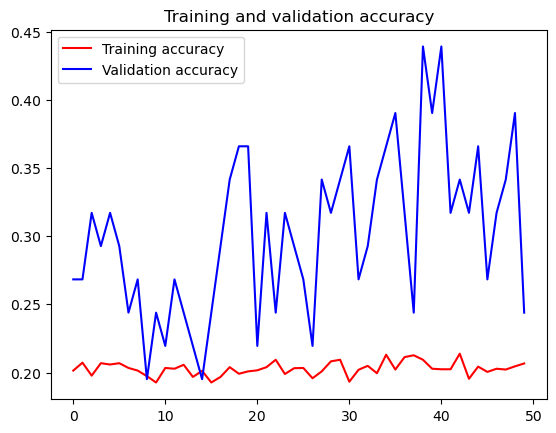

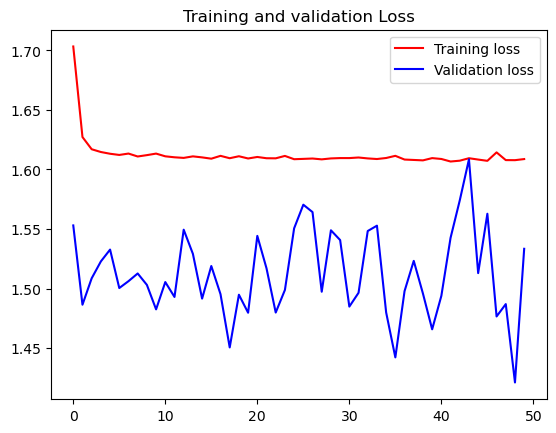

1/1 [==============================] - 1s 1s/step
Predicted class: Stem end Rot, Confidence: 0.22361987829208374


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, Reshape, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
data_dir = r'D:\\GAN PROJECT\\DATASET\\Training Data'
categories = ["Alternaria", "Anthracnose", "Black Mould Rot", "Healthy", "Stem end Rot"]

# Function to load and preprocess images
def load_images(data_dir):
    image_paths = []
    labels = []
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for image_filename in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, image_filename))
            labels.append(category)
    return image_paths, labels

# Load and preprocess the images
image_paths, labels = load_images(data_dir)

# Convert labels to numeric values
label_map = {category: idx for idx, category in enumerate(categories)}
numeric_labels = [label_map[label] for label in labels]

# Convert images to arrays
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

combined_images = np.array([preprocess_image(path) for path in image_paths])
combined_labels = np.array(numeric_labels)

# Convert labels to categorical
combined_labels = to_categorical(combined_labels, num_classes=len(categories))

# Split data
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# GAN Definitions

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 16 * 16, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile GAN
def compile_gan(generator, discriminator, gan):
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
compile_gan(generator, discriminator, gan)

# Training GAN
def train_gan(epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        real_labels = np.ones((batch_size, 1))
        
        # Generate fake images
        noise = np.random.randn(batch_size, latent_dim)
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        # Train discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss_real[0]} | D accuracy: {100 * d_loss_real[1]}] [G loss: {g_loss}]")

# Define training parameters
latent_dim = 100
epochs = 2000  # Increased epochs for GAN training
batch_size = 64  # Reduced batch size

train_gan(epochs, batch_size, latent_dim)

# Generate synthetic images
def generate_synthetic_images(num_images, latent_dim):
    noise = np.random.randn(num_images, latent_dim)
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2.0  # Rescale to [0, 1]
    return synthetic_images

synthetic_images = generate_synthetic_images(5000, latent_dim)

# Combine real and synthetic data
synthetic_labels = np.random.choice(len(categories), size=synthetic_images.shape[0])
synthetic_labels = to_categorical(synthetic_labels, num_classes=len(categories))
combined_images = np.concatenate((train_images, synthetic_images), axis=0)
combined_labels = np.concatenate((train_labels, synthetic_labels), axis=0)

# Train classifier
classifier_batch_size = 64
train_generator = datagen.flow(combined_images, combined_labels, batch_size=classifier_batch_size)

base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

classifier_epochs = 50  # Increased epochs for classifier
history = model.fit(train_generator, epochs=classifier_epochs, validation_data=(test_images, test_labels), verbose=1)

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Save the classifier model
model.save('mango_disease_model_with_gan.h5')

# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Training Data\Black Mould Rot\aspergillus_042.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"Predicted class: {predicted_class}, Confidence: {confidence}")


In [10]:
# Function to predict with confidence
def predict_image(image_path, model):
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = categories[class_idx]
    confidence = predictions[0][class_idx]
    
    return class_label, confidence

# Example usage
new_image_path = r'D:\GAN PROJECT\Testing Data\Stem end Rot\lasio_136.jpg'
predicted_class, confidence = predict_image(new_image_path, model)
print(f"Predicted class: {predicted_class}, Confidence: {confidence}")

OSError: [Errno 22] Invalid argument: '"D:\\GAN PROJECT\\Testing Data\\Stem end Rot\\lasio_136.jpg"'